In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  7 22:49:16 2019

@author: RedFox GIS & Remote Sensing, Aaron P.
"""
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from matplotlib import pyplot as plt
import seaborn as sns
from rasterio.plot import show, show_hist
from rasterio.features import shapes
from skimage.segmentation import quickshift, mark_boundaries
from skimage import io, color
from skimage.filters.rank import entropy
from skimage.morphology import disk
from rasterstats import zonal_stats
import geopandas as gpd
from shapely.geometry import shape
from sklearn.ensemble import RandomForestClassifier

In [2]:
indata = '/Users/aaron/gdrive/projects/image_segmentation_project/data/river_subset.tif'
training_data = '/Users/aaron/gdrive/projects/image_segmentation_project/data/training_data.shp'
outdata = '/Users/aaron/Desktop/temp/RF_results_entropy.shp'

## Read image and calculate statistics

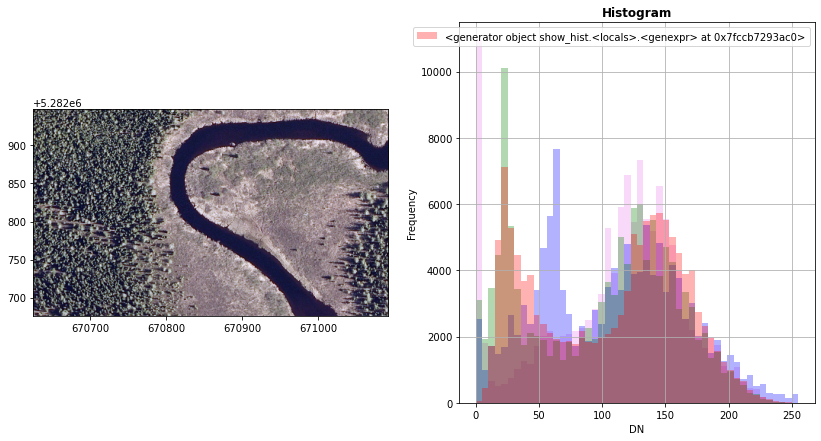

In [3]:
# Read in 4 band NAIP image
dataset = rasterio.open(indata)

fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
show(dataset, ax=axrgb)
show_hist(dataset, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

# Get image bounding box info
sr = dataset.crs
bounds = dataset.bounds
affine = dataset.transform

    


## Segment Image

Quickshift number of segments: 406


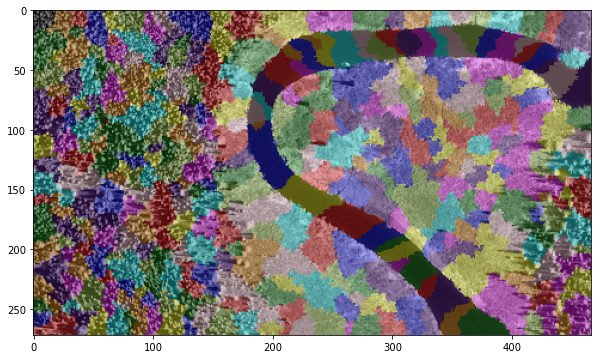

In [13]:
img = io.imread(indata)
segments = quickshift(img, kernel_size=3, convert2lab=False, max_dist=6, ratio=0.5).astype('int32')
print("Quickshift number of segments: %d" % len(np.unique(segments)))

# View the segments via Python
plt.figure(figsize=(10,10))
plt.imshow(color.label2rgb(segments, img, bg_label=0))

## Calculate NDVI

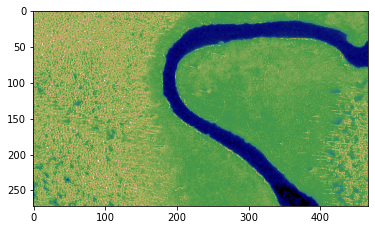

<AxesSubplot:>

In [14]:
red = dataset.read(3).astype(float)
nir = dataset.read(4).astype(float)

#Allow 0 in division
np.seterr(divide='ignore', invalid='ignore')

ndvi = np.empty(dataset.shape, dtype=rasterio.float32)
check = np.logical_or ( red > 0, nir > 0 )
ndvi = np.where ( check,  (nir - red ) / ( nir + red ), -999 )
show(ndvi, cmap='gist_earth')

## Calculate Entropy and Texture Metrics

In [15]:
# Entropy
# https://scikit-image.org/docs/dev/auto_examples/filters/plot_entropy.html#sphx-glr-auto-examples-filters-plot-entropy-py
entr_img = entropy(ndvi, disk(10))



/Users/aaron/anaconda3/envs/geopandas/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Calculate zonal statistics

In [16]:
polys = []
for shp, value in shapes(segments, transform=affine):
    polys.append(shp)

ndvi_mean = zonal_stats(polys, ndvi, affine = affine, stats="mean")
entropy_mean = zonal_stats(polys, entr_img, affine = affine, stats="mean")
red_mean = zonal_stats(polys, dataset.read(1), affine = affine, stats="mean")
green_mean = zonal_stats(polys, dataset.read(2), affine = affine, stats="mean")
blue_mean = zonal_stats(polys, dataset.read(3), affine = affine, stats="mean")
nir_mean = zonal_stats(polys, dataset.read(4), affine = affine, stats="mean")



/Users/aaron/anaconda3/envs/geopandas/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


## Convert segments to geodataframe

In [21]:
geom = [shape(i) for i in polys]
polys_gdf = gpd.GeoDataFrame({'geometry':geom})

# Set sr
polys_gdf.crs = sr

## Add metrics to geodataframe

In [22]:
# NDVI
# Add a ndvi field and calculate mean value
ndvi_series = pd.Series([f['mean'] for f in ndvi_mean])
polys_gdf['ndvi'] = ndvi_series.values

# Entropy
entropy_series = pd.Series([f['mean'] for f in entropy_mean])
polys_gdf['entropy_mean'] = entropy_series.values

# RGBnIR
red_series = pd.Series([f['mean'] for f in red_mean])
polys_gdf['red_mean'] = red_series.values

green_series = pd.Series([f['mean'] for f in green_mean])
polys_gdf['green_mean'] = green_series.values

blue_series = pd.Series([f['mean'] for f in blue_mean])
polys_gdf['blue_mean'] = blue_series.values

nir_series = pd.Series([f['mean'] for f in nir_mean])
polys_gdf['nir_mean'] = nir_series.values




In [23]:
# Check results
polys_gdf

,geometry,ndvi,entropy_mean,red_mean,green_mean,blue_mean,nir_mean
0,"POLYGON ((670625.002 5282947.795, 670625.002 5...",0.359136,6.605524,85.554455,86.514851,86.019802,141.376238
1,"POLYGON ((670871.002 5282947.795, 670871.002 5...",-0.080569,1.046453,168.947090,153.579365,159.925926,134.383598
2,"POLYGON ((670971.002 5282947.795, 670971.002 5...",-0.018852,2.414273,161.146119,147.310502,148.114155,139.972603
3,"POLYGON ((670992.002 5282947.795, 670992.002 5...",-0.056795,1.349926,180.982533,164.231441,168.196507,145.624454
4,"POLYGON ((670923.002 5282947.795, 670923.002 5...",-0.046072,1.229393,143.475000,126.758333,132.129167,118.408333
...,...,...,...,...,...,...,...
481,"POLYGON ((670898.002 5282694.795, 670898.002 5...",-0.034642,1.535019,154.750000,138.368421,142.347368,131.247368
482,"POLYGON ((670913.002 5282699.795, 670913.002 5...",-0.020341,2.032392,164.096606,148.898172,149.524804,142.148825
483,"POLYGON ((670995.002 5282699.795, 670995.002 5...",-0.911014,0.056602,37.395620,27.310949,63.919708,4.029197
484,"POLYGON ((671055.002 5282702.795, 671055.002 5...",-0.098643,2.801175,67.272206,60.510029,79.200573,64.418338


## Generate training Data

In [24]:
# Read in shapefile with ground truth classes
gdf = gpd.read_file(training_data)

class_names = gdf['label'].unique()

# Assign integer to class names
class_ids = np.arange(class_names.size) + 1

# Add a new column and assign integer value to correspoding label
gdf['id'] = gdf['label'].map(dict(zip(class_names, class_ids)))

# Spatial Join
data = gpd.sjoin(gdf, polys_gdf, how='left')

data.head()

,id,label,geometry,index_right,ndvi,entropy_mean,red_mean,green_mean,blue_mean,nir_mean
0,1,forest,POINT (670655.345 5282861.972),163,0.281459,6.175729,68.232258,71.600000,77.438710,111.361290
1,1,forest,POINT (670756.515 5282891.345),116,0.249655,6.500036,66.337209,68.666667,78.426357,110.112403
2,1,forest,POINT (670761.003 5282933.771),25,0.300445,6.215158,60.284507,63.952113,73.157746,105.969014
3,1,forest,POINT (670646.778 5282934.179),20,0.337188,6.689742,80.356322,82.465517,81.827586,133.037356
4,1,forest,POINT (670651.266 5282748.564),364,0.166562,5.289358,40.459459,40.585586,56.045045,75.144144


## Split data into train and test sets

In [25]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

x = data[['ndvi', 'entropy_mean', 'red_mean', 'green_mean', 'blue_mean', 'nir_mean']]
y = data[['id']]

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # 70% training and 30% test

In [26]:
x.head()

,ndvi,entropy_mean,red_mean,green_mean,blue_mean,nir_mean
0,0.281459,6.175729,68.232258,71.600000,77.438710,111.361290
1,0.249655,6.500036,66.337209,68.666667,78.426357,110.112403
2,0.300445,6.215158,60.284507,63.952113,73.157746,105.969014
3,0.337188,6.689742,80.356322,82.465517,81.827586,133.037356
4,0.166562,5.289358,40.459459,40.585586,56.045045,75.144144


## Classify

In [27]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a RF Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train.values.ravel())

y_pred=clf.predict(x_test)

In [28]:
y_pred

array([2, 1, 2, 3, 1, 3, 2, 3, 3, 3, 1, 2, 1, 2, 2, 1, 3, 1])

In [29]:
x_test

,ndvi,entropy_mean,red_mean,green_mean,blue_mean,nir_mean
30,-0.746626,0.551876,33.600000,28.125170,62.152381,12.198639
3,0.337188,6.689742,80.356322,82.465517,81.827586,133.037356
35,-0.756044,0.467845,35.207692,27.615385,60.811538,9.392308
51,0.011703,3.737173,131.965278,120.295139,123.128472,124.180556
17,0.303087,6.128957,66.421569,68.529412,76.228758,111.428105
49,-0.053178,1.922473,154.147619,141.619048,147.304762,130.592857
27,-0.788582,0.288901,31.263393,27.046875,61.177455,9.242188
52,0.040917,4.556584,131.604096,124.044369,124.843003,133.529010
43,-0.052110,1.203095,167.161572,152.039301,156.528384,139.493450
58,-0.045336,1.957396,163.224924,145.966565,150.975684,134.091185


## Assess Accuracy

In [30]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


## Assess feature importance

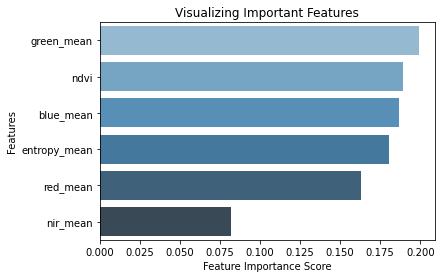

In [33]:
# https://www.datacamp.com/community/tutorials/random-forests-classifier-python

feature_imp = pd.Series(clf.feature_importances_, index=x_test.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, palette="Blues_d")

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()


## Predict on all segments

In [34]:
# Get the original data and convert to 2-D array
data2 = pd.DataFrame(polys_gdf[['ndvi', 'entropy_mean', 'red_mean', 'green_mean', 'blue_mean', 'nir_mean']])

# Predict
y2_pred=clf.predict(data2) # Creates an array of predictions

# Append predict array to geopandas gdf
polys_gdf['class'] = y2_pred

<AxesSubplot:>

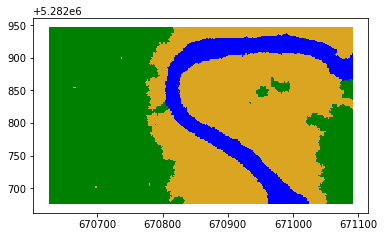

In [65]:
polys_gdf

# Map it
color_mapping = {1: "green", 2: "blue", 3: "goldenrod"} # Custom color scheme
polys_gdf.plot(color=polys_gdf["class"].map(color_mapping), alpha = 1.0) # Apply colors based on class column



In [66]:
# Dissolve segments
dissolved_segments = polys_gdf.dissolve(by = 'class', aggfunc = 'sum')
dissolved_segments.crs = sr
dissolved_segments.to_file(outdata)

# Export all segs to shp
#polys_gdf.crs = sr # Make sure the SR is defined the same as input data
#polys_gdf.to_file(outdata)

## Testing entropy and texture

In [68]:
# In progress...
# Eventually add entropy and texture metrics to raster stack for classification

# Also try Gabor Filter Banks
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html

# And GLCM Texture Features
from skimage.feature import greycomatrix, greycoprops
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html
glcm = greycomatrix(dataset.read(4), distances=[5], angles=[0], levels=256,
                    symmetric=True, normed=True)

#plt.imshow(glcm, cmap = 'gray')